# Imports:

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

## Discrete Data + Probability

Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

# Acquire:

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8])



In [3]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [4]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [5]:
#data types mainly object, timestamp needs to be altered.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [6]:
df.shape

(13978, 7)

------

# Prepare:

In [7]:
# change timestamp to datetime which excludes brackets and +0000
#have to make time stamp a string in order to remove this excessive text.
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex =True)

In [8]:
df.head(1)

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""


In [9]:
#change timestamp datatype to datetime 
# the 1 within the .replace is directing the
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

#set dattime to index
df = df.set_index('timestamp').sort_index()

In [10]:
#created new column where converted bytes to MB so bytes/1024**2
df['size_mb'] = df['size']/1024**2
#dropping bytes column
df.drop(columns = 'size', inplace =True)

In [11]:
df.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,NaN,"""python-requests/2.21.0""",0.488753
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,NaN,"""python-requests/2.21.0""",0.003396
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,NaN,"""python-requests/2.21.0""",0.486472
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,NaN,"""python-requests/2.21.0""",0.486377
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,NaN,"""python-requests/2.21.0""",0.488246


In [12]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488246


--------

### Looking into discrete unique values and creating probabilities.

In [13]:
#will focus on status since 499 and 301 appear unique.
df.status.value_counts()

200    13960
499       16
301        2
Name: status, dtype: int64

In [14]:
def unique_count(df):
    for col in df.columns:
        print(df[col].value_counts())

In [15]:
unique_count(df)

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
52.91.30.150          1
45.23.250.16          1
54.145.52.184         1
3.92.201.136          1
95.31.16.121          1
97.105.15.120         1
3.88.129.158          1
35.174.209.2          1
34.207.64.242         1
54.172.14.223         1
34.229.70.250         1
95.31.18.119          1
Name: ip, dtype: int64
GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items

- Conditional probability 
    $$ {P(A|B) = }\frac{\text{P(A U B)}}{\text{P(B)}} $$

In [16]:
# get the counts of status in the dataset
#how many times the value of a particular value shows up in the data.
# once we know count, can figure prob = count/total
#in order for us to calculate probabilty we need to know each individual count.
status_df = pd.DataFrame(df.status.value_counts().reset_index().rename(columns = {'index': 'status', 'status': 'status_count'}))
status_df
# we basically calculated pb here


,status,status_count
0,200,13960
1,499,16
2,301,2


In [17]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1
GET /api/v1/items/HTTP/1.1                          1
GET /api/V1/HiZach! HTTP/1.1                        1
GET /api/v1/items&page=0 HTT

In [18]:
status_df.value_counts()

status  status_count
499     16              1
301     2               1
200     13960           1
dtype: int64

In [19]:
# need to calculate the probability of each status
#probability is the number over the total so take each unique status total count and divide by count of entrie status field count.
status_df2 = pd.DataFrame(df.status.value_counts(dropna =False)/df.status.count()).reset_index().rename(columns = {'index':'status', 'status':'status_prob'})
status_df2

,status,status_prob
0,200,0.998712
1,499,0.001145
2,301,0.000143


In [20]:
#now want to merge these to the original status df
status_df = status_df.merge(status_df2)
status_df.head()

,status,status_count,status_prob
0,200,13960,0.998712
1,499,16,0.001145
2,301,2,0.000143


In [21]:
stats = pd.DataFrame(status_df['status_prob'].value_counts())
stats.reset_index()
stats.index *100

Float64Index([0.014308198597796537, 99.87122621261983, 0.1144655887823723], dtype='float64')

In [22]:
status_df[status_df.status_prob < .02]

,status,status_count,status_prob
1,499,16,0.001145
2,301,2,0.000143


In [23]:
#creating data frame which gives the value_count of each ip(pb)
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().rename(columns={'index': 'ip', 'ip': 'ip_count'})

In [24]:
ip_df

,ip,ip_count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21
5,24.26.242.9,21
6,35.175.171.137,2
7,52.87.230.102,2
8,70.121.214.34,2
9,52.90.165.200,1


In [25]:
#need to calculate the probability
ip_df2 = pd.DataFrame((df.ip.value_counts(dropna=False))/df.ip.count()).reset_index().rename(columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df2.head()

,ip,ip_proba
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,68.201.219.223,0.001502


## 

In [26]:
# merge the two data frames create above into a single one:
ip_df = ip_df.merge(ip_df2)


# look at rows where ip_proba is less than 0.01
ip_df[ip_df.ip_proba < 0.01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,35.175.171.137,2,0.000143
7,52.87.230.102,2,0.000143
8,70.121.214.34,2,0.000143
9,52.90.165.200,1,0.000072
10,52.91.30.150,1,0.000072
11,45.23.250.16,1,0.000072
12,54.145.52.184,1,0.000072
13,3.92.201.136,1,0.000072


In [27]:
#plot the ip_count

def plot_unique(df,col1, col2):
    plt.figure(figsize=(12, 4))
    splot = sns.barplot(data=ip_df, x = col1, y = col2, ci = None)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', xytext = (0, 10), 
                       textcoords = 'offset points'
                       )
        plt.xticks(rotation='vertical')

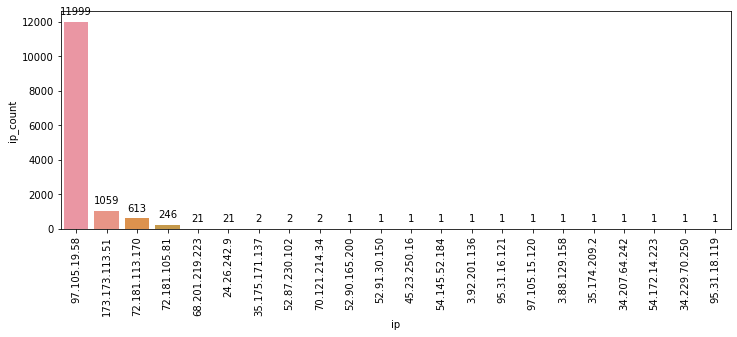

In [28]:
plot_unique(ip_df, ip_df.ip, ip_df.ip_count)

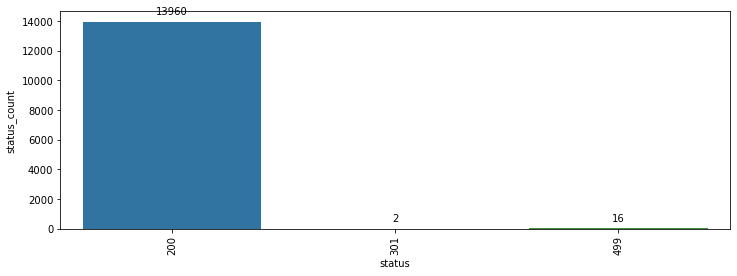

In [29]:
plot_unique(status_df, status_df.status, status_df.status_count)

In [30]:
rm_df = pd.DataFrame(df.request_method.value_counts(dropna = False)).reset_index().rename(columns = {'index':'request_method', 'request_method':'request_method_count'})
rm_df

,request_method,request_method_count
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229
3,GET / HTTP/1.1,107
4,GET /documentation HTTP/1.1,100
5,GET /favicon.ico HTTP/1.1,26
6,GET /api/v1//api/v1/items HTTP/1.1,11
7,GET /api/v1/items/api/v1/items HTTP/1.1,7
8,GET /api/v1/items/next_page HTTP/1.1,5
9,GET /api/v1/ HTTP/1.1,4


In [31]:
rm_df2 = pd.DataFrame(df.request_method.value_counts(dropna = False)/df.request_method.count()).reset_index().rename(columns = {'index':'request_method', 'request_method':'request_method_proba'})
rm_df2

,request_method,request_method_proba
0,GET /api/v1/sales HTTP/1.1,0.887323
1,GET /api/v1/items HTTP/1.1,0.076191
2,GET /api/v1/stores HTTP/1.1,0.016383
3,GET / HTTP/1.1,0.007655
4,GET /documentation HTTP/1.1,0.007154
5,GET /favicon.ico HTTP/1.1,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,0.000358
9,GET /api/v1/ HTTP/1.1,0.000286


In [32]:
rm_df = rm_df.merge(rm_df2)

In [33]:
rm_df.head(10)

,request_method,request_method_count,request_method_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286


In [34]:
# Merge probabilities with all data (train + new data):

# Where the IP address is new, i.e. not seen in the training 
#  dataset, fill the probability with a value of 0.
#reset to get away from datatime index!
#what if new ip shows up no in original df, that is what the fillna will do for every new value we see fill with zero.
# basically we are filling the original with values we figure from new df.
#df gets filled with ip_df ip_proba

df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df = df.reset_index().merge(rm_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')

In [35]:
df.head()

,ip,request_method,status,destination,request_agent,size_mb,ip_count,ip_proba,request_method_count,request_method_proba
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488753,11999,0.85842,12403,0.887323
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,11999,0.85842,1065,0.076191
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486472,11999,0.85842,12403,0.887323
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486377,11999,0.85842,12403,0.887323
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488246,11999,0.85842,12403,0.887323


### Detecting anomalies by establishing a baseline and evaluate as new data arrives.


#### Establish Baseline:

In [36]:
# #establish baseline 

train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [37]:
train.head()

,ip,request_method,status,destination,request_agent,size_mb,ip_count,ip_proba,request_method_count,request_method_proba
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488753,11999,0.85842,12403,0.887323
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,11999,0.85842,1065,0.076191
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486472,11999,0.85842,12403,0.887323
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486377,11999,0.85842,12403,0.887323
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488246,11999,0.85842,12403,0.887323


In [38]:
request_method_proba = train.groupby('request_method').size().div(len(train))

In [39]:
request_given_ip = pd.DataFrame(train.groupby(['ip', 'request_method']).size().div(len(train)).\
            
                               div(request_method_proba, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(columns={0: 'proba_request_given_ip'})
                              )

In [40]:
request_given_status = pd.DataFrame(train.groupby(['status', 'request_method']).size().div(len(train)).\
            
                               div(request_method_proba, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(columns={0: 'proba_request_given_status'})
                              )

In [41]:
request_given_ip

,ip,request_method,proba_request_given_ip
0,173.173.113.51,GET / HTTP/1.1,0.009346
1,173.173.113.51,GET /api/v1/items HTTP/1.1,0.176526
2,173.173.113.51,GET /api/v1/sales HTTP/1.1,0.065710
3,173.173.113.51,GET /api/v1/stores HTTP/1.1,0.235808
4,173.173.113.51,GET /documentation HTTP/1.1,0.010000
...,...,...,...
56,97.105.19.58,GET /api/v1/store HTTP/1.1,1.000000
57,97.105.19.58,GET /api/v1/stores HTTP/1.1,0.694323
58,97.105.19.58,GET /api/v1items HTTP/1.1,0.500000
59,97.105.19.58,GET /documentation HTTP/1.1,0.930000


In [42]:
train.head()

,ip,request_method,status,destination,request_agent,size_mb,ip_count,ip_proba,request_method_count,request_method_proba
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488753,11999,0.85842,12403,0.887323
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,11999,0.85842,1065,0.076191
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486472,11999,0.85842,12403,0.887323
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486377,11999,0.85842,12403,0.887323
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488246,11999,0.85842,12403,0.887323


In [43]:
# calculate count for each combination of ip and request_method
# we can easy add a count of how many times ip and request happens.
request_ip_count = pd.DataFrame(train.groupby(['ip', 'request_method'])['status'].\
                              count().reset_index().\
                              rename(columns={'status': 'ip_request_count'}))

request_ip_count

,ip,request_method,ip_request_count
0,173.173.113.51,GET / HTTP/1.1,1
1,173.173.113.51,GET /api/v1/items HTTP/1.1,188
2,173.173.113.51,GET /api/v1/sales HTTP/1.1,815
3,173.173.113.51,GET /api/v1/stores HTTP/1.1,54
4,173.173.113.51,GET /documentation HTTP/1.1,1
...,...,...,...
56,97.105.19.58,GET /api/v1/store HTTP/1.1,3
57,97.105.19.58,GET /api/v1/stores HTTP/1.1,159
58,97.105.19.58,GET /api/v1items HTTP/1.1,1
59,97.105.19.58,GET /documentation HTTP/1.1,93


In [44]:
# calculate count for each combination of ip and request_method
# we can easy add a count of how many times ip and request happens.
request_status_count = pd.DataFrame(train.groupby(['status', 'request_method'])['ip'].\
                              count().reset_index().\
                              rename(columns={'ip': 'status_request_count'}))

request_status_count

,status,request_method,status_request_count
0,200,GET / HTTP/1.1,107
1,200,GET /api/V1/HiZach! HTTP/1.1,1
2,200,GET /api/v1 HTTP/1.1,1
3,200,GET /api/v1/ HTTP/1.1,4
4,200,GET /api/v1//api/v1/items HTTP/1.1,11
5,200,GET /api/v1//api/v1/items/next_page HTTP/1.1,1
6,200,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,1
7,200,GET /api/v1/helloclass! HTTP/1.1,1
8,200,GET /api/v1/items HTTP/1.1,1061
9,200,GET /api/v1/items&page=0 HTTP/1.1,1


In [45]:
request_ip = request_given_ip.merge(request_ip_count)
request_status = request_given_status.merge(request_status_count)

In [46]:
df = df.reset_index().merge(request_ip, on=['ip', 'request_method'], how='left').fillna(value=0).set_index('timestamp')
df = df.reset_index().merge(request_status, on=['status', 'request_method'], how='left').fillna(value=0).set_index('timestamp')
df.head(3)

,ip,request_method,status,destination,request_agent,size_mb,ip_count,ip_proba,request_method_count,request_method_proba,proba_request_given_ip,ip_request_count,proba_request_given_status,status_request_count
timestamp,,,,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488753,11999,0.85842,12403,0.887323,0.877610,10885.0,0.999032,12391.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,11999,0.85842,1065,0.076191,0.670423,714.0,0.996244,1061.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486472,11999,0.85842,12403,0.887323,0.877610,10885.0,0.999032,12391.0


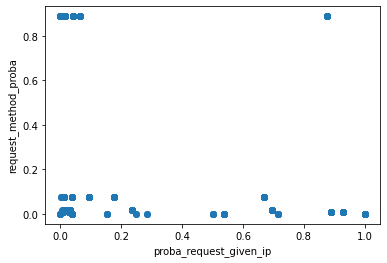

In [49]:
# plot the probabilities

plt.scatter(df.proba_request_given_ip,df.request_method_proba)
plt.xlabel('proba_request_given_ip')
plt.ylabel('request_method_proba');

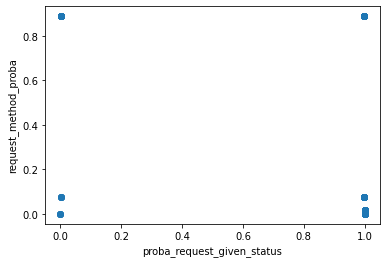

In [50]:
# plot the probabilities

plt.scatter(df.proba_request_given_status,df.request_method_proba)
plt.xlabel('proba_request_given_status')
plt.ylabel('request_method_proba');

In [51]:
#filtering df to prob status < .2, and rm_proba <.2 there is less of these values so they are more unique.
# these are ip addresses which are newer or happen rarely.
df[(df['request_method_proba'] > 0.2) & (df['proba_request_given_ip'] > 0.8)]

,ip,request_method,status,destination,request_agent,size_mb,ip_count,ip_proba,request_method_count,request_method_proba,proba_request_given_ip,ip_request_count
timestamp,,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488753,11999,0.85842,12403,0.887323,0.87761,10885.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486472,11999,0.85842,12403,0.887323,0.87761,10885.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486377,11999,0.85842,12403,0.887323,0.87761,10885.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488246,11999,0.85842,12403,0.887323,0.87761,10885.0
2019-04-16 19:34:50,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.487092,11999,0.85842,12403,0.887323,0.87761,10885.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-17 12:55:12,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.487846,11999,0.85842,12403,0.887323,0.87761,10885.0
2019-04-17 12:55:12,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.487519,11999,0.85842,12403,0.887323,0.87761,10885.0
2019-04-17 12:55:13,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488072,11999,0.85842,12403,0.887323,0.87761,10885.0
